![logo](https://climate.copernicus.eu/sites/default/files/2025-03/logoline_c3s.png)

# Tutorial on Sea Surface Temperature (SST) and Sea Ice Surface Temperature (IST) using Climate Data from C3S

**This notebook can be run on free online platforms, such as Binder, Kaggle and Colab, or they can be accessed from GitHub. The links to run this notebook in these environments are provided here, but please note they are not supported by ECMWF.**

[![binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/ecmwf-training/c3s-training-submodule-sat-obs-ocean/develop?labpath=sea-surface-ice-surface-temperature.ipynb)
[![kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-training/c3s-training-submodule-sat-obs-ocean/blob/develop/sea-surface-ice-surface-temperature.ipynb)
[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ecmwf-training/c3s-training-submodule-sat-obs-ocean/blob/develop/sea-surface-ice-surface-temperature.ipynb)
[![github](https://img.shields.io/badge/Open%20in-GitHub-black?logo=github)](https://github.com/ecmwf-training/c3s-training-submodule-sat-obs-ocean/blob/develop/sea-surface-ice-surface-temperature.ipynb)

## Learning objectives 🎯

In this tutorial we will access data from the Climate Data Store (CDS) of the Copernicus Climate Change Service (C3S), and analyse climatologies and trends in global sea surface and sea-ice surface temperatures. The L4 (gap-free) daily data used for this tutorial are the products C3S2_312b-SST_IST-CDR_v1.0 and C3S2_312b-SST_IST-ICDR_v1.0

Examples of filenames are  YYYYMMDD120000-C3S2-L4_GHRSST-SSTdepth-ISTskin-DMIOI-GLOB_CDR1.0-v02.0-fv01.0.nc and YYYYMMDD120000-C3S2-L4_GHRSST-SSTdepth-ISTskin-DMIOI-GLOB_ICDR1.0-v02.0-fv01.0.nc, where YYYY is the year, MM is the month and DD is the day. The Climate Data Record (CDR) covers the period 1982-2021 and is extended through the Interim CDR (ICDR) for 2022-2024.

The tutorial consists of the following steps: Calculating a climatology of surface temperatures for the period 1991-2020 and visualising anomalies of the last available year (2024) with respect to the normal

## Prepare your environment

Before we begin we must prepare our environment. This includes installing the Application Programming Interface (API) of the CDS, and importing the various python libraries that we will need.

### Set up CDSAPI and your credentials

The code below will ensure that the `cdsapi` package is installed. If you have not setup your `~/.cdsapirc` file with your credenials, you can replace `None` with your credentials that can be found on the [how to api](https://cds.climate.copernicus.eu/how-to-api) page (you will need to log in to see your credentials).

In [ ]:
!pip install -q cdsapi
# If you have already setup your .cdsapirc file you can leave this as None
cdsapi_key = None
cdsapi_url = None

### (Install and) Import libraries

We will be working with data in NetCDF format. To best handle this data we will use libraries for working with multidimensional arrays, in particular Xarray. We will also need libraries for plotting and viewing data, in this case we will use Matplotlib and Cartopy. Lastly we need the scipy package to compute basic statistics.

In [ ]:
# Packages
# CDS API
# Import cdsapi

import os
import glob
import sys
from datetime import datetime
import numpy as np
from scipy import stats
import xarray as xr
from fnmatch import fnmatch
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
import cartopy.feature as cfeature

### Specify data directory

Here we specify a data directory in which we will download our data and all output files that we will generate:

In [ ]:
BASEPATH = 'define_basepath' # This is the base directory of your analysis, where your daily files must be located
DATADIR = f'{BASEPATH}/data'
if not os.path.exists(DATADIR):os.makedirs(DATADIR)

## Explore data

### Search for the data

To search for data, visit the CDS website: http://cds.climate.copernicus.eu.
Here you can search for SST and IST data using the search bar. The data we need for this tutorial is the L4 Global SST/IST Climate Data Record which can be found under the [Sea surface temperature daily data from 1981 to present derived from satellite observations](https://cds.climate.copernicus.eu/datasets/satellite-sea-surface-temperature?tab=overview). The dataset to select is the L4 SST/IST CDR (###please confirm this and we can add a link once the dataset is published in the CDS###).

Having selected the correct dataset, we now need to specify what product type, variables, temporal and geographic coverage we are interested in. These can all be selected in the **Download data** tab. In this tab a form appears in which we will select the following parameters to download:

- Processing level: `L4`
- Sensor on satellite: `Combined product SST/IST`
- Version: `1.0`
- Variable: `analysed_st`
- Year: `1982 to 2024`
- Month: `all`
- Time: `12:00` (default)
- Geographical area: `global`
- Format: `NetCDF`

At the end of the download form, select **"Show API request"**. This will reveal a block of code, which you can simply copy and paste into a cell of your Jupyter Notebook (see cell below).

### Download the data

Having copied the API request into the cell below, running this will retrieve and download the data you requested into your local directory. However, before you run the cell below, the **terms and conditions** of this particular dataset need to have been accepted in the CDS. The option to view and accept these conditions is given at the end of the download form, just above the **"Show API request"** option.

In [ ]:
import cdsapi

dataset = "satellite-sea-surface-temperature"
request = {
    "processinglevel": "level_4",
    "sensor_on_satellite": "combined_sst_ist_product",
    "version": "1_0",
    "year": [
        "1981", "1982", "1983",
        "1984", "1985", "1986",
        "1987", "1988", "1989",
        "1990", "1991", "1992",
        "1993", "1994", "1995",
        "1996", "1997", "1998",
        "1999", "2000", "2001",
        "2002", "2003", "2004",
        "2005", "2006", "2007",
        "2008", "2009", "2010",
        "2011", "2012", "2013",
        "2014", "2015", "2016",
        "2017", "2018", "2019",
        "2020", "2021", "2022"
    ],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "day": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12",
        "13", "14", "15",
        "16", "17", "18",
        "19", "20", "21",
        "22", "23", "24",
        "25", "26", "27",
        "28", "29", "30",
        "31"
    ]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()

### Inspect data

Now that we have downloaded the data, we can inspect it. We have requested the data in NetCDF format. This is a commonly used format for array-oriented scientific data. To read and process this data we will make use of the [Xarray](http://xarray.pydata.org/en/stable/) library. Xarray is an open source project and Python package that makes working with labelled multi-dimensional arrays simple and efficient. We will read the data from our NetCDF file into an [xarray.Dataset](https://xarray.pydata.org/en/stable/generated/xarray.Dataset.html).

First we define the BASEPATH - this is the starting path of the analysis, hence, this is where the downloaded data should be located.

In [ ]:
BASEPATH = 'define_basepath'
DATAPATH = f'{BASEPATH}/data'
path_out = f'{BASEPATH}/figures'

Now let's display the data from a given day

In [ ]:
# Load data
filename = '20240330120000-C3S2-L4_GHRSST-SSTdepth-ISTskin-DMIOI-GLOB_ICDR1.0-v02.0-fv01.0.nc'
date = filename[:8]
path_in = f'{DATAPATH}/daily/2024/03'
print(f'{path_in}/2024/03/{filename}')
ds = xr.open_dataset(f'{path_in}/{filename}')

# Read data
SST = ds['analysed_sst'].squeeze() # sea surface temperature in Kelvin
ST = ds['analysed_st'].squeeze()  # surface temperature (SST/IST) in Kelvin
SST_unc = ds['analysis_error_sst'].squeeze() # Uncertainty of sea surface temperature in degrees celcius
ST_unc = ds['analysis_error_st'].squeeze()  # Uncertainty of surface temperature (SST/IST) in degrees celcius
mask = ds['mask'].squeeze() # Land, ocean, ice mask
lon = ds['lon'] # longitude
lat = ds['lat'] # lattitude


Now we can visualize our newly created Xarray dataset

In [ ]:
ds

<xarray.Dataset>
Dimensions:                (lat: 3600, lon: 7200, time: 1)
Coordinates:
  * lon                    (lon) float32 -179.975 -179.925 ... 179.925 179.975
  * lat                    (lat) float32 -89.975 -89.924995 ... 89.925 89.975006
  * time                   (time) datetime64[ns] 2024-03-30T12:00:00
Data variables:
    analysed_st            (time, lat, lon) float32 ...
    analysis_error_st      (time, lat, lon) float32 ...
    mask                   (time, lat, lon) float32 ...
    sea_ice_fraction       (time, lat, lon) float32 ...
    analysed_sst           (time, lat, lon) float32 ...
    sea_ice_fraction_flag  (time, lat, lon) float32 ...
    analysis_error_sst     (time, lat, lon) float32 ...
Attributes:
    Conventions:                CF-1.4, Unidata Observation Dataset v1.0
    title:                      Global Sea and Ice Surface Temperature, L4, 5...
    summary:                    DMI Sea and Ice Surface Temperature analysis ...
    references:                 Høyer, J. L. and She, J., Optimal interpolati...
    institution:                Danish Meteorological Institute, DMI
    history:                    Version 1.0
    license:                    These data are available free of charge under...
    id:                         DMI-L4UHskin-GLOB-DMI_OI
    naming_authority:           org.ghrsst
    product_version:            Version 1.0
    uuid:                       d59e0252-bb82-45e1-ac85-04dbecc307c5
    gds_version_id:             2.0
    netcdf_version_id:          netcdf-4.4.1.1.6
    date_created:               20240825T070856Z
    file_quality_level:         3
    spatial_resolution:         0.05 degrees
    time_coverage_start:        20240330T000000Z
    time_coverage_end:          20240331T000000Z
    geospatial_lon_min:         -179.975
    geospatial_lon_max:         179.975
    geospatial_lat_min:         -89.975
    geospatial_lat_max:         89.975
    source:                     ESA SST CCI v3.0 and C3S v3.0 L3U, AASTIv2 IS...
    platform:                   NOAA-6 to NOAA-19, ERS-1, ERS-2, ENVISAT, SEN...
    platform_vocabulary:        CEOS mission table
    instrument:                 AVHRR, ATSR, ATSR-2, AATSR, SLSTR, AMSR-E, AMSR2
    instrument_vocabulary:      CEOS instrument table
    Metadata_Conventions:       Unidata Dataset Discovery v1.0
    metadata_link:              http://data.nodc.noaa.gov/NESDIS_DataCenters/...
    keywords:                   Oceans > Ocean Temperature > Sea Surface Temp...
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    standard_name_vocabulary:   NetCDF Climate and forecast (CF) Metadata Con...
    geospatial_lat_units:       degrees north
    geospatial_lon_units:       degrees east
    geospatial_lat_resolution:  0.05
    geospatial_lon_resolution:  0.05
    geospatial_bounds:          (-179.975, 179.975, -89.975, 89.975)
    acknowledgment:             Please acknowledge the use of these data with...
    creator_name:               Danish Meteorological Institute - DMI Copenhagen
    creator_email:              myocean_po@dmi.dk
    creator_url:                http://ocean.dmi.dk/satellite/
    project:                    Copernicus Climate Change Service (C3S) project
    publisher_name:             C3S and DMI
    publisher_url:              https://climate.copernicus.eu/
    publisher_email:            https://climate.copernicus.eu/help-and-suppor...
    processing_level:           L4
    cdm_data_type:              grid
    comment:                    IN NO EVENT SHALL DMI OR ITS REPRESENTATIVES ...

Let's display the sea and seaice surface temperature dataarray

In [ ]:
print(ST)

<xarray.DataArray 'analysed_st' (lat: 3600, lon: 7200)>
[25920000 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 -179.975 -179.925 -179.875 ... 179.925 179.975
  * lat      (lat) float32 -89.975 -89.924995 -89.875 ... 89.925 89.975006
    time     datetime64[ns] 2024-03-30T12:00:00
Attributes:
    standard_name:  surface_temperature
    long_name:      analysed sea and ice surface temperature
    units:          kelvin
    comment:        
    source:         AASTI v2 SST/IST, ESA CCI SST and C3S SST L2P products
    valid_range:    [-6000  4500]


#### Change temperature units from Kelvin to Celsius

Notice that the sea surface temperatures and the sea and sea ice surface temperatures are in units of `Kelvin`, the base unit for temperature in the International System of Units (SI). If you want to convert the values from `Kelvin` to `degrees Celsius`, you have to subtract 273.15.

In [ ]:
SST_degc = SST - 273.15
ST_degc =  ST - 273.15

**Simple visualisation and statistics**

For a simple vizualisation of the data one can use the script below which creates a simple geographical representation of the data using cartopy


In [ ]:
def geographical_simple(lat, lon, data, varname, path_out, date):
    # Make simple geographical plot
    fig, ax = plt.subplots(nrows=1,ncols=1,
                            subplot_kw={'projection': ccrs.PlateCarree()},
                            figsize=(15,8))
    #ax.coastlines()
    ax.set_global()

    if varname.upper()=='ST':
        labelname = 'SST and IST'
        vmin = -40
        vmax = 35
    elif varname.upper()=='SST':
        labelname = 'SST and Sub-Ice SST'
        vmin = -2
        vmax = 35
    elif varname.upper()=='ST_UNC':
        labelname = 'SST and IST Uncertainties'
        vmin = 0
        vmax = 5
    elif varname.upper()=='SST_UNC':
        labelname = 'SST and Sub-Ice SST Uncertainties'
        vmin= 0.2
        vmax = 1.5
    else:
        labelname=varname
        vmin=np.nanmin(data)
        vmax=np.nanmax(data)

    img = ax.imshow(
        np.flipud(data),
        extent=[lon.min(), lon.max(), lat.min(), lat.max()],
        origin='upper',
        cmap='viridis',
        vmin=vmin,
        vmax=vmax,
        interpolation='none',
        transform=ccrs.PlateCarree()
    )

    label = f'{labelname} [°C]' if varname.upper() in ['ST', 'SST', 'ST_UNC', 'SST_UNC'] else labelname
    cbar = plt.colorbar(img, ax=ax, orientation='vertical', label=label)

    ax.set_title(f'C3S Global L4 {labelname} for {date}')

    savename = f'GBL_{varname}_{date}_geographical.png'
    plt.savefig(f'{path_out}/{savename}', bbox_inches='tight')
    plt.show()
    plt.close()

In [ ]:
def basic_statistics(data, varname):
    print(f'##### BASIC STATISTICS FOR {varname} ######\n')

    mean_value = np.round(np.nanmean(data), 2).item()
    median_value = np.round(np.nanmedian(data), 2)
    std_dev = np.round(np.nanstd(data), 2)
    max_value = np.round(np.nanmax(data), 2)
    min_value = np.round(np.nanmin(data), 2)

    print(f'Mean value: {mean_value:.2f} \n')
    print(f'Median value: {median_value:.2f} \n')
    print(f'Standard deviation: {std_dev:.2f} \n')
    print(f'Maximum value: {max_value:.2f} \n')
    print(f'Minimum value: {min_value:.2f} \n')

Let's make geographical plots and compute basic statistics for the landmask, along with the Sea Surface temperature and Sea and Sea-ice Surface temperature variables and their uncertainty fields.

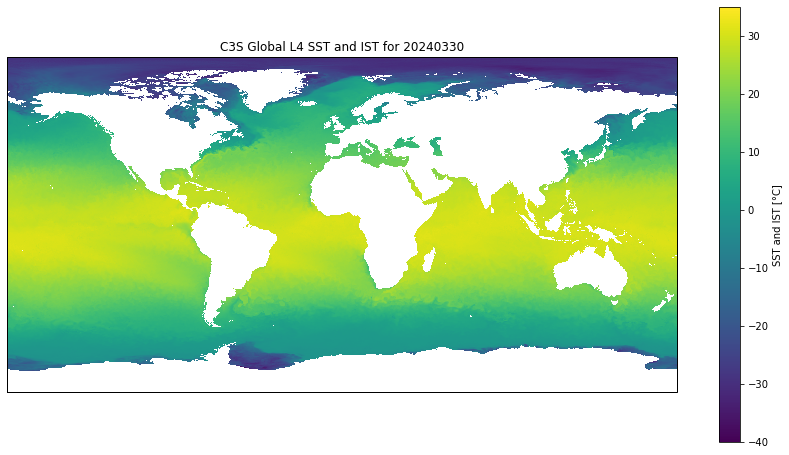

##### BASIC STATISTICS FOR ST ######

Mean value: 10.62 

Median value: 15.44 

Standard deviation: 18.18 

Maximum value: 34.56 

Minimum value: -40.89 



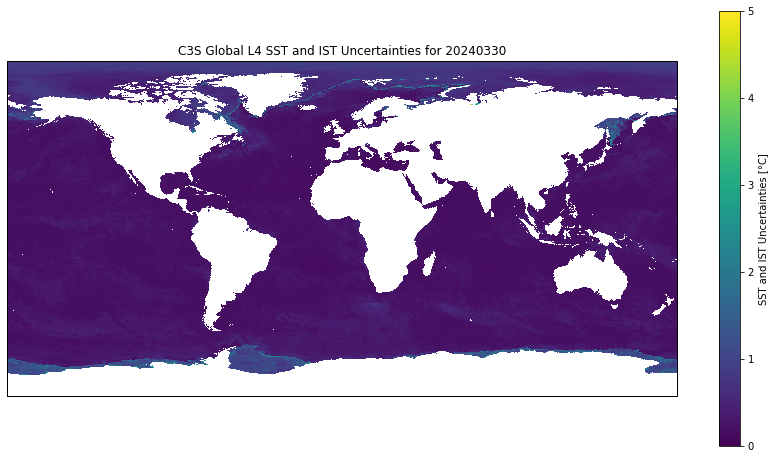

##### BASIC STATISTICS FOR ST_unc ######

Mean value: 0.36 

Median value: 0.25 

Standard deviation: 0.26 

Maximum value: 28.31 

Minimum value: 0.00 



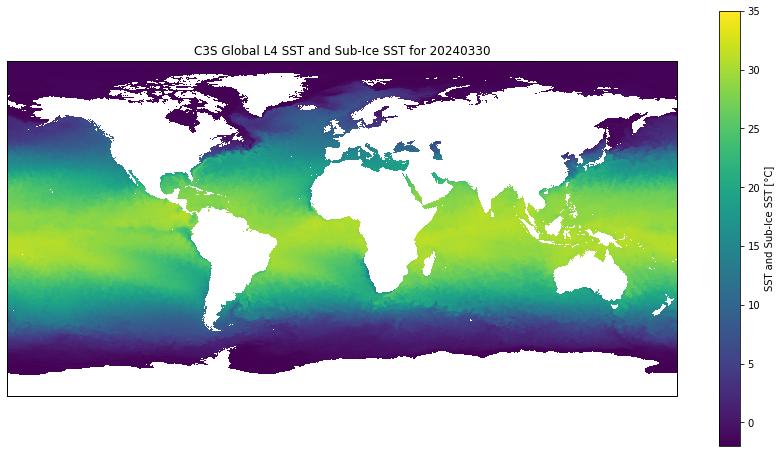

##### BASIC STATISTICS FOR SST ######

Mean value: 14.21 

Median value: 15.44 

Standard deviation: 12.07 

Maximum value: 34.56 

Minimum value: -2.24 



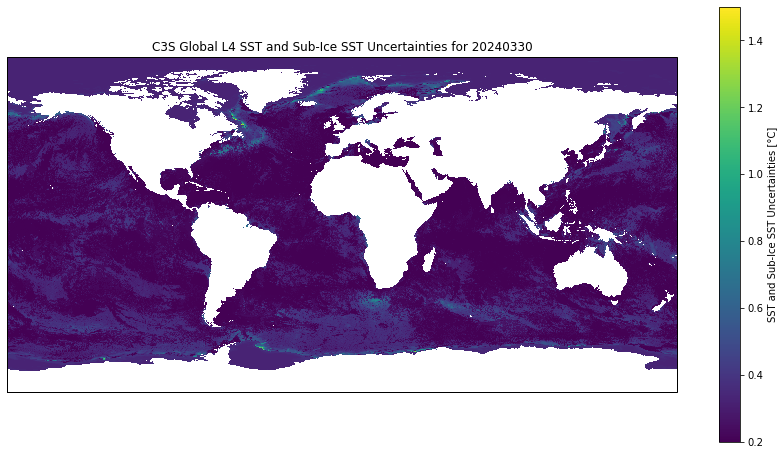

##### BASIC STATISTICS FOR SST_unc ######

Mean value: 0.27 

Median value: 0.25 

Standard deviation: 0.08 

Maximum value: 1.65 

Minimum value: 0.13 



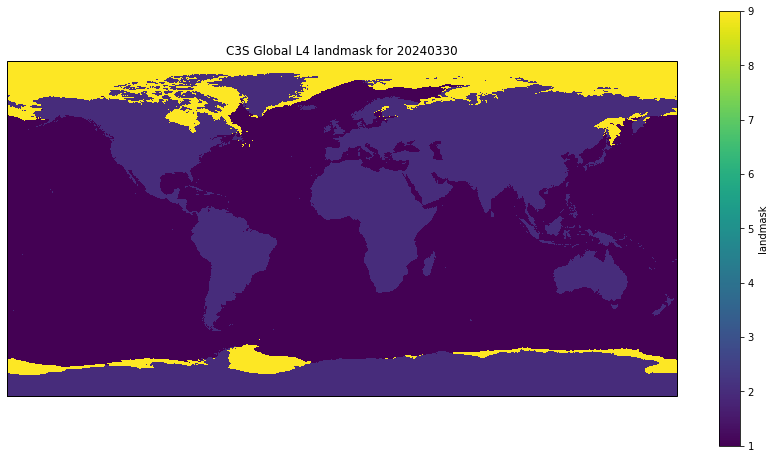

##### BASIC STATISTICS FOR landmask ######

Mean value: 2.26 

Median value: 1.00 

Standard deviation: 2.48 

Maximum value: 9.00 

Minimum value: 1.00 



In [ ]:
# Make geographical plots

# Sea and Sea-ice Surface temperature
geographical_simple(lat, lon, ST_degc, 'ST', path_out, date)
basic_statistics(ST_degc, 'ST')

# Uncertainty of Sea and Sea-ice Surface temperature
geographical_simple(lat, lon, ST_unc, 'ST_unc', path_out, date)
basic_statistics(ST_unc, 'ST_unc')

# Sea Surface temperature
geographical_simple(lat, lon, SST_degc, 'SST', path_out, date)
basic_statistics(SST_degc, 'SST')

# Uncertainty of Sea Surface temperature
geographical_simple(lat, lon, SST_unc, 'SST_unc', path_out, date)
basic_statistics(SST_unc, 'SST_unc')

# Land, Ocean, Ice mask
geographical_simple(lat, lon, mask, 'landmask', path_out, date)
basic_statistics(mask, 'landmask')

## Calculate climate normals

### Standard reference period and climate normals

Anthropogenic activities and natural variations from years to decades shape the Earth's climate. In order to evaluate anomalous conditions of a specific month or year, the World Meteorological Organization (WMO) defines `standard reference periods` used to create `climate normals`. `Climate normals` can be considered as the typical climate for the period the normals are based on.

Until 2020, the most current and widely used standard reference period was the 30-year range of 1981-2010. With the start of 2021, the WMO recommended updating the climate normal reference period to the range 1991-2020.

First, let us calculate the sea and sea-ice surface temperature climate normal for the reference period 1991-2020.

This includes two steps. First we collect all daily reanalysis files for the input year and calculate monthly means (Step 2.0), subsequently in Step 2.1 these files are used to calculate the climatology.

The resulting object contains for each year from 1982 to 2024 the average annual global mean surface temperature.

#### Combine the daily files into monthly composites

This step can be skipped as there are already files with monthly means available for the SST IST C3S dataset. The naming convention of these files are as follow:

* yyyymm-C3S2-L4_GHRSST-SSTdepth-ISTskin-DMIOI-GLOB_ICDR1.0_monthly-v02.0-fv01.0.nc for 2022-2024

* yyyymm-C3S2-L4_GHRSST-SSTdepth-ISTskin-DMIOI-GLOB_CDR1.0_monthly-v02.0-fv01.0.nc for 1982-2021

In [ ]:
# Load daily files
path_in  = f'{DATAPATH}/daily/'
# Define output path
path_out = f'{BASEPATH}/gbl_monthly_mean_climatology/' #(dimension months,lat,lon)
# Define the range of the climatology
years = np.arange(1991,2020)

# Loop through all years
for year in years:
    print('Working on year ' + str(year) + '...')
    print('-----------------------')
    # Get all the L4 files for the year
    pattern = str(year)+'*L4*.nc'
    filelist = []
    print('Getting filenames...')
    for (root, dirs, files) in os.walk(path_in):#, topdown=False):
        for name in files:
            if fnmatch(name, pattern):
                filelist.append(path_in + name[0:4] + '/' + name[4:6] + '/' + name)
    filelist = sorted(filelist)
    print('Done!')

    # Open the multiple files with xarray's mfdataset
    print('Reading data...')
    data = xr.open_mfdataset(filelist, combine='nested', concat_dim='time',compat='broadcast_equals',join='override')
    print('Done!')

    # Calculate monthly mean grids
    print('Calculating monthly mean SST...')
    data_mm = data.groupby('time.month').mean('time')

    data_mm.attrs = data.attrs
    data.close()
    # Adjust global attributes
    data_mm.attrs['stop_time'] = str(year) + '1231T000000Z'
    data_mm.attrs['time_coverage_end'] = str(year) + '1231T000000Z'
    print('Done!')

    # Save to file
    print('Saving to file...')
    data_mm.to_netcdf(path_out + str(year) + '_GBL_MM.nc')
    print('Done!')

    data_mm.close()
    print(str(year) + ' complete!\n')


#### Combine monthly composites to compute the climatology 1991-2020

In [ ]:
path = f'{BASEPATH}/gbl_monthly_mean_climatology/' # path to save climatology to

# Get all the files
print('Getting filenames...')
for (root, dirs, files) in os.walk(path, topdown=False):
    files = glob.glob(path+'*_MM.nc') # should be changed?
files = sorted(files)
print('Done!')

# Load all 1991-2020 monthly mean climatologies
print('Loading annual files...')
data = xr.open_mfdataset(files, concat_dim='month',compat='broadcast_equals',join='override', combine='nested')
print('Done!')

# Calculate the mean of all same months in each gridpoint
print('Calculating 1991-2020 climatology...')
data_clim = data.groupby('month').mean()

# Put the SST values on a numpy array
st_clim = data_clim['analysed_st'].values
print('Done!')

# Save to .nc and .npy file
print('Saving to file...')
np.save(path + 'GBL_ST_CLIM_1991_2020.npy',st_clim)
data_clim.to_netcdf(path + 'GBL_ST_CLIM_1991_2020.nc')
print('Done!')

## Anomaly calculation

The next step now is to calculate the anomaly of a specific year with respect to the climate normal. The term anomaly refers to the deviation of a value from the long-term average. Positive or negative anomalies indicate that the average temperatures of a particular year were respectively warmer or cooler than the reference value.

Let us calculate the sea and sea-ice surface temperature anomaly for the year 2024. In a first step, we select the average near-surface temperature values for the year 2024 from the xarray. DataArray object `yearly_mean`. With the xarray function `sel()`, you can select a data array based on coordinate labels. The coordinate label of interest is `year=2024`.


#### Create yearly composites

In [ ]:
# Define year
year = 2024
print('Working on year ' + str(year))
print('--------------------')
path_in  = f'{DATAPATH}/daily/'
path_out = f'{BASEPATH}/annual_files/' # one file per year (dimension 365/366 days X lat,lon)

# Get all the L4 files for the year
pattern = str(year)+'*L4*.nc'
filelist = []
print('Getting filenames...')
for (root, dirs, files) in os.walk(path_in):#, topdown=False):
    for name in files:
        if fnmatch(name, pattern):
           filelist.append(path_in + name[0:4] + '/' + name[4:6] + '/' + name)
filelist = sorted(filelist)
print('Done!')

# Open all the files together with xarray's mfdataset
print('Loading files...')
data = xr.open_mfdataset(filelist,concat_dim='time',compat='broadcast_equals',join='override', combine='nested')
print('Files loaded')


# Modify file global attributes
data.attrs['stop_time'] = str(year)+'1231T235959Z'
data.attrs['time_coverage_end'] = str(year)+'1231T235959Z'
data.attrs['date_created'] = datetime.now().strftime('%Y%m%dT%H%M%SZ')
# data.attrs['spatial_resolution'] = '0.05 degrees'

if not os.path.exists(path_out):
    os.makedirs(path_out)

# Set output file name
if year>=2021:
    file_out = path_out+str(year)+'-C3S2-L4_GHRSST-SSTdepth-ISTskin-DMIOI-GLOB_ICDR1.0-v02.0-fv01.0.nc'
else:
    file_out = path_out+str(year)+'-C3S2-L4_GHRSST-SSTdepth-ISTskin-DMIOI-GLOB_CDR1.0-v02.0-fv01.0.nc'
# Delete old file if already exists
if os.path.exists(file_out):
    os.remove(file_out)

# Save regridded dataset to netCDF file
print('Saving regridded data to netCDF file...')
data.to_netcdf(file_out)
print('NetCDF file created!')


#### Compute anomaly and vizualise

In [ ]:
def geographical_simple(lat, lon, data, varname, year, path_out, savename):
    # Make simple geographical plot
    fig, ax = plt.subplots(nrows=1,ncols=1,
                            subplot_kw={'projection': ccrs.PlateCarree()},
                            figsize=(15,8))

    ax.set_global()

    if varname.upper()=='ST':
        labelname = 'SST and IST'

    elif varname.upper()=='SST':
        labelname = 'SST and Sub-Ice SST'

    img = ax.imshow(
        np.flipud(data),
        extent=[lon.min(), lon.max(), lat.min(), lat.max()],
        origin='upper',
        cmap='viridis',
        vmin=-6,
        vmax=6,
        interpolation='none',
        transform=ccrs.PlateCarree()
    )

    label = f'{labelname} [°C]'
    cbar = plt.colorbar(img, ax=ax, orientation='vertical', label=label)
    ax.set_title(f'C3S Global L4 Annual Mean {labelname} Anomaly for {year}')
    plt.savefig(f'{path_out}/{savename}', bbox_inches='tight')
    plt.show()
    plt.close()

path_out = f'{BASEPATH}/figures'

# Define year to examine
year = 2024

# Read annual file
if year>=2021:
    ds = xr.open_dataset(BASEPATH + '/annual_files/'+str(year)+'-C3S2-L4_GHRSST-SSTdepth-ISTskin-DMIOI-GLOB_ICDR1.0-v02.0-fv01.0.nc')
else:
    ds = xr.open_dataset(BASEPATH + '/annual_files/'+str(year)+'-C3S2-L4_GHRSST-SSTdepth-ISTskin-DMIOI-GLOB_CDR1.0-v02.0-fv01.0.nc')

# Load data and climatology
sst_yyyy = ds['analysed_st'].values.mean(axis=0)
sst_1991_2020 = np.load(BASEPATH + '/gbl_monthly_mean_climatology/GBL_ST_CLIM_1991_2020.npy')
sst_1991_2020_mean = sst_1991_2020.mean(axis=0)
# Compute anomaly
sst_yma = sst_yyyy - sst_1991_2020_mean

lon = ds['lon'].values
lat = ds['lat'].values

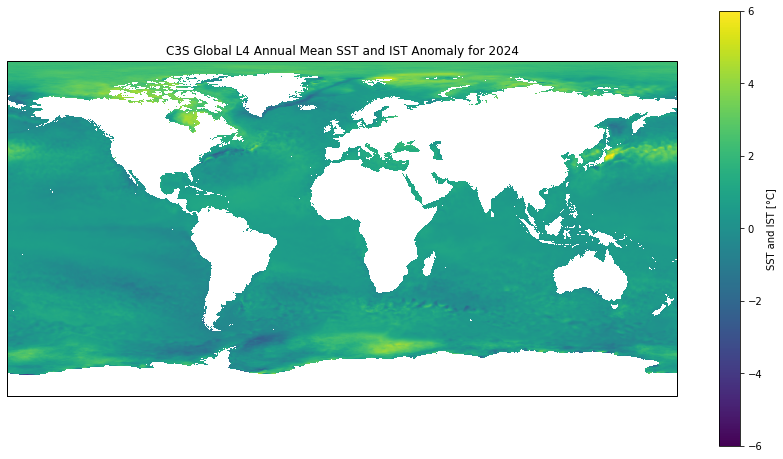

In [ ]:
# Create map
# ----------
savename = f'GBL_Annual_Mean_ST_anom_{year}.png'
geographical_simple(lat, lon, sst_yma, 'ST', year, path_out, savename)

Let's examine spatial patterns in the anomalies, looking at the full region, the northern third and the southern third.

In [ ]:
# Calculate statistics
# --------------------

# Filter out outliers in the whole region
# med = np.nanmedian(sst_yma)
# mad = stats.median_abs_deviation(sst_yma,axis=None,nan_policy='omit')
# sst_yma[sst_yma <= med - 3*mad] = np.nan
# sst_yma[sst_yma >= med + 3*mad] = np.nan

# Stats for the whole region
sst_yma_full_mean = np.nanmean(sst_yma)
sst_yma_full_std = np.nanstd(sst_yma)

print(f'Full region, mean difference to climatology: {sst_yma_full_mean:.2f} ± {sst_yma_full_std:.2f} [°C]')

# Stats for the Arctic region (top third)
sst_yma_full_mean = np.nanmean(sst_yma[1800-600:,:])
sst_yma_full_std = np.nanstd(sst_yma[1800-600:,:])

print(f'Arctic region (northern third), mean difference to climatology: {sst_yma_full_mean:.2f} ± {sst_yma_full_std:.2f} [°C]')

# Stats for the Antarctic region (bottom third)
sst_yma_full_mean = np.nanmean(sst_yma[:600,:])
sst_yma_full_std = np.nanstd(sst_yma[:600,:])

print(f'Antarctic region (southern third), mean difference to climatology: {sst_yma_full_mean:.2f} ± {sst_yma_full_std:.2f} [°C]')


Full region, mean difference to climatology: 0.77 ± 0.86 [°C]
Arctic region (northern third), mean difference to climatology: 0.90 ± 0.88 [°C]
Antarctic region (southern third), mean difference to climatology: 0.78 ± 1.06 [°C]


## Take home messages 📌

- Annual anomalies for 2024 compared to the climatology (1191-2020) are more pronounced for the higher latitudes of the Northern and Southern Hemisphere (particularly sea ice covered regions in the Arctic) along with very dynamic ocean regions like the Kuroshio current (east of Japan) and parts of the warm blob in the North Pacific (off the west coast of North America). 
- Particularly for the high anomalies in the Arctic, the finding is is consistent with the effect of the Arctic amplification, leading to a much higher temperature increase for the Arctic region.
- We also observe a slight negative trend in the surface temperature at the expected ice edge near the Fram Stait, i.e. the passage between Greenland and Svalbard.